# Importing and basic definitions

In [0]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as scheduler
import torch.nn.functional as F
from scipy.stats.stats import pearsonr

import spacy

from nltk import download
from nltk.corpus import stopwords

# RMSE loss used for the training of the NN-based approaches  
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

### Importing Data

In [0]:
# Download and unzip the competition data
from os.path import exists
if not exists('ende_data.zip'):
    !wget -O ende_data.zip https://competitions.codalab.org/my/datasets/download/c748d2c0-d6be-4e36-9f12-ca0e88819c4d
    !unzip ende_data.zip

### Computing Sentence Embeddings 

In [0]:
# Download the word embeddings from spaCy
!spacy download en_core_web_md
!spacy link en_core_web_md en300

!spacy download de_core_news_md
!spacy link de_core_news_md de300

# Pre-processing

#### Pre-processing with Spacy

In [33]:
# Downloads stopwords from nltk
download('stopwords')

# Get unique stopwords for English and German
stop_words_en = set(stopwords.words('english'))
stop_words_de = set(stopwords.words('german'))

# Tokenizes and lemmatise the words of the sentence before getting the vector representation 
def get_sentence_emb(line,nlp,lang):
    if lang == 'en':
        text = line.lower()
        l = [token.lemma_ for token in nlp.tokenizer(text)]
        l = ' '.join([word for word in l if word not in stop_words_en])

    elif lang == 'de':
        text = line.lower()
        l = [token.lemma_ for token in nlp.tokenizer(text)]
        l = ' '.join([word for word in l if word not in stop_words_de])

    sen = nlp(l)
    return sen.vector

# Given a file it produces vector representations for each sentence
def get_embeddings(f,nlp,lang):
    file = open(f) 
    lines = file.readlines() 
    sentences_vectors =[]

    for l in lines:
        vec = get_sentence_emb(l,nlp,lang)
        if vec is not None:
            # vec = np.mean(vec)
            vec = vec
            sentences_vectors.append(vec)
        else:
            sentences_vectors.append(0)

    return sentences_vectors


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Getting Training and Validation Sets

In [0]:
# Load spacy embeddings
nlp_de = spacy.load('de300')
nlp_en = spacy.load('en300')

In [0]:
# gets the embeddings for training and validation
de_train_src = get_embeddings("./train.ende.src",nlp_en,'en')
de_train_mt = get_embeddings("./train.ende.mt",nlp_de,'de')

f_train_scores = open("./train.ende.scores",'r')
de_train_scores = f_train_scores.readlines()

de_val_src = get_embeddings("./dev.ende.src",nlp_en,'en')
de_val_mt = get_embeddings("./dev.ende.mt",nlp_de,'de')

# loads scores
f_val_scores = open("./dev.ende.scores",'r')
de_val_scores = f_val_scores.readlines()

In [0]:
# Put the features into a torch Tensor with dimension (-1, 300 + 300)
X_train = torch.cat((torch.tensor(de_train_src), torch.tensor(de_train_mt)), 1)

X_val = torch.cat((torch.tensor(de_val_src), torch.tensor(de_val_mt)), 1)

# Load the scores
train_scores = torch.Tensor([float(t.strip()) for t in de_train_scores])
y_train_de =train_scores

val_scores = torch.Tensor([float(t.strip()) for t in de_val_scores])
y_val_de = val_scores

# FFNN-based approach

In [39]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):  
        super(FFNN, self).__init__()
        
        # hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # output layer
        self.fc3 = nn.Linear(hidden_dim, num_classes)  
    
    def forward(self, x):
        out = F.leaky_relu(self.fc1(x))
        out = F.leaky_relu(self.fc2(out))
        out = self.fc3(out)
        return out

# for testing purposes
def PearsonLoss(x, y):
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)    
    return (torch.ones(1).cuda() - torch.sum(vx * vy * torch.rsqrt(torch.sum(vx ** 2)) * torch.rsqrt(torch.sum(vy ** 2))))**2

EPOCHS = 1000
LRATE = 0.001
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
OUTPUT_DIM = 1

model = FFNN(600, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=LRATE)


loss_fn = RMSELoss()

# Input and label tensors
feature = X_train
target = train_scores
validation = X_val
val_labels = val_scores

## Training loop
print(f'Will train for {EPOCHS} epochs')
for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()
  
    predictions = model(feature).squeeze(1)

    loss = loss_fn(predictions, target)
    train_loss = loss.item()

    loss.backward()

    optimizer.step()
    
    # Every 50 epochs prints the current loss and validation loss and correlation
    if epoch % 50 == 0 and epoch != 0:
        with torch.no_grad():
            v_pred = model(validation).squeeze(1)
            v_loss = loss_fn(v_pred, val_labels)
            val_loss = v_loss.item()
            print(f'| Epoch: {epoch:02d} | Train Loss: {train_loss:.3f} | Validation Loss: {val_loss:.3f} | Pearson Val: {pearsonr(v_pred, val_labels)[0]}')

Will train for 1000 epochs
| Epoch: 50 | Train Loss: 0.699 | Validation Loss: 0.899 | Pearson Val: 0.06956420809863421
| Epoch: 100 | Train Loss: 0.456 | Validation Loss: 0.986 | Pearson Val: 0.05335538318104857
| Epoch: 150 | Train Loss: 0.286 | Validation Loss: 1.024 | Pearson Val: 0.024140525071744322
| Epoch: 200 | Train Loss: 0.196 | Validation Loss: 1.046 | Pearson Val: 0.00995131795386998
| Epoch: 250 | Train Loss: 0.156 | Validation Loss: 1.058 | Pearson Val: -0.004926421229309887
| Epoch: 300 | Train Loss: 0.157 | Validation Loss: 1.070 | Pearson Val: -0.014373878820719365
| Epoch: 350 | Train Loss: 0.116 | Validation Loss: 1.077 | Pearson Val: -0.018914876224661693
| Epoch: 400 | Train Loss: 0.102 | Validation Loss: 1.082 | Pearson Val: -0.022042178423698815
| Epoch: 450 | Train Loss: 0.089 | Validation Loss: 1.086 | Pearson Val: -0.02422973110266329
| Epoch: 500 | Train Loss: 0.083 | Validation Loss: 1.088 | Pearson Val: -0.026289212891855162
| Epoch: 550 | Train Loss: 0.077

# CNN-based approach

In [0]:
# CNN designed for text in the shape (-1, 1, 2, 300). This treats the text
# as a 2x300 image on which the convolutions are applied.

class CNN(nn.Module):
  def __init__(self, window_size, output_dim, dropout):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Conv2d(
      in_channels=1, out_channels=64,
      kernel_size=(2, window_size), padding=(1,0))
    
    self.bn1 = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(
      in_channels=64, out_channels=32,
      kernel_size=(2, window_size), padding=(1,0))
    
    self.bn2 = nn.BatchNorm2d(32)
    self.dropout = nn.Dropout(dropout)

    self.fc = nn.Linear(3840, output_dim)
    self.mp = nn.MaxPool2d((2,5),padding=(1,0))
        
  def forward(self, x):
    o = self.conv1(x)
    o = self.bn1(o)
    o = F.leaky_relu(o)

    o = self.conv2(o)
    o = self.bn2(o)
    o = F.leaky_relu(o)

    pooled = self.mp(o)
    
    pooled = pooled.view(x.shape[0],-1)
    
    dropped = self.dropout(pooled)
    preds = self.fc(dropped)
    
    return preds

In [0]:
# For the CNN we need the text in the shape (samples, 1, 2, 600)
X_train = torch.cat((torch.tensor(de_train_src).view(7000,1,1,300), torch.tensor(de_train_mt).view(7000,1,1,300)), 2)
X_val = torch.cat((torch.tensor(de_val_src).view(1000,1,1,300), torch.tensor(de_val_mt).view(1000,1,1,300)), 2)

#Scores
train_scores = torch.Tensor([float(t.strip()) for t in de_train_scores])
y_train_de =train_scores

val_scores = torch.Tensor([float(t.strip()) for t in de_val_scores])
y_val_de = val_scores

In [0]:
# all the data, used for multiple validations later on
all_x = torch.cat([X_train, X_val], 0)
all_scores = torch.cat([train_scores, val_scores], 0)

In [0]:
from copy import deepcopy

device = torch.device('cuda')
EPOCHS = 50
LRATE = 2e-4

EMBEDDING_DIM = 50
OUTPUT_DIM = 1
BATCH_SIZE = 64

# keep track of best ever
best_RMSE_val = 1000
best_model = None

while True:
    # create random data split
    idxs = np.random.permutation(all_x.shape[0])
    model = CNN(window_size=50, output_dim=1, dropout=0.2).cuda()

    optimizer = optim.Adam(model.parameters(), lr=LRATE)
    loss_fn = RMSELoss()

    feature_train = all_x[idxs[:7000]]
    target_train = all_scores[idxs[:7000]]

    feature_valid1 = all_x[idxs[7000:7500]]
    target_valid1 = all_scores[idxs[7000:7500]]

    feature_valid2 = all_x[idxs[7500:]]
    target_valid2 = all_scores[idxs[7500:]]

    # keeps track of old model
    old_model = deepcopy(model)
    old_loss = 10000

    print(f'Will train for {EPOCHS} epochs')
    break_out = False
    counter = 0
    for epoch in range(EPOCHS):
        t = torch.randperm(7000)
        feature_train = feature_train[t]
        target_train = target_train[t]
        model.train()
        
        i = 0
        new_loss = 0

        for i in range(7000//BATCH_SIZE - 1):
            train = feature_train[BATCH_SIZE*i:BATCH_SIZE*(i+1)]
            labels = target_train[BATCH_SIZE*i:BATCH_SIZE*(i+1)]
            
            optimizer.zero_grad()

            predictions = model(train.cuda()).squeeze(1)
            loss = loss_fn(predictions, labels.cuda())
            train_loss = loss.item()
            
            new_loss += train_loss

            loss.backward()

            optimizer.step()

        if new_loss > old_loss: # if it didn't improve
            model = old_model # reload previous model
            LRATE *= 0.75 # decrease the learning rate
            for g in optimizer.param_groups:
                g['lr'] = LRATE
            counter += 1

            if counter > 15: # if there haven't been any improvement stop
                break_out = True
        else: # if there was an improvement
            old_model = deepcopy(model) # save the current model
            old_loss = new_loss # and the current loss
            counter = 0

        with torch.no_grad():
            predictions_valid1 = model(feature_valid1.cuda()).squeeze(1)
            valid_loss1 = loss_fn(predictions_valid1, target_valid1.cuda()).item()

            predictions_valid2 = model(feature_valid2.cuda()).squeeze(1)
            valid_loss2 = loss_fn(predictions_valid2, target_valid2.cuda()).item()
            
        # print validation loss and correlation
        if epoch % 1 == 0 and epoch != 0:
            print(f'| Epoch: {epoch:02} | Train Loss: {new_loss / (7000 // BATCH_SIZE):.3f} | Val. Loss 1: {valid_loss1:.3f} |  Val. Loss 2: {valid_loss2:.3f} | Pearson Val: {pearsonr(predictions_valid.cpu(), target_valid.cpu())[0]}')

        # breaks if no improvement
        if break_out:
            with torch.no_grad():
                predictions_valid = model(feature_valid.cuda()).squeeze(1)
                valid_loss = loss_fn(predictions_valid, target_valid.cuda()).item()
            
            if valid_loss <= best_RMSE_val:
                best_RMSE_val = valid_loss
                best_model = deepcopy(model)
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_RMSE_val': best_RMSE_val,
                    }, "./model.pth")
                
            print(f"Restarting - best val loss: {best_RMSE_val}")

            break

# Classical approaches

In [0]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## SVR - hyperparameter search and averaging

In [0]:
from sklearn.svm import SVR
from scipy.stats.stats import pearsonr

# save results for averages
results = [0,0,0,0,0,0]

n = 5 # number of iterations to average over
d = 12 # degree of poly kernel

for i in range(n):
    # create a random split for training and validation
    idxs = np.random.permutation(all_x.shape[0])

    feature_train = all_x[idxs[:7000]].view(7000,-1)
    target_train = all_scores[idxs[:7000]].view(7000)

    feature_valid1 = all_x[idxs[7000:7500]].view(500,-1)
    target_valid1 = all_scores[idxs[7000:7500]].view(500)

    feature_valid2 = all_x[idxs[7500:]].view(500,-1)
    target_valid2 = all_scores[idxs[7500:]].view(500)

    for j, c in enumerate(range(2, 22, 2)):
        c /= 10
        k = 'rbf' # can be changed manually

        clf_t = SVR(kernel=k, C=c, degree=12)
        clf_t.fit(feature_train, target_train)
        
        predictions1 = clf_t.predict(feature_valid1)
        pearson1 = pearsonr(target_valid1, torch.Tensor(predictions1))
        predictions2 = clf_t.predict(feature_valid2)
        pearson2 = pearsonr(target_valid2, torch.Tensor(predictions2))
        
        print(f'C: {c} | Pearson1 {pearson1[0]} | Pearson2 {pearson2[0]}')
        results[j] += (pearson1[0] + pearson2[0]) / 2

_ = [print(x/n) for x in results]

## Random Forest Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor

# produce a random split
idxs = np.random.permutation(all_x.shape[0])

feature_train = all_x[idxs[:7000]].view(7000,-1)
target_train = all_scores[idxs[:7000]].view(7000)

feature_valid1 = all_x[idxs[7000:7500]].view(500,-1)
target_valid1 = all_scores[idxs[7000:7500]].view(500)

feature_valid2 = all_x[idxs[7500:]].view(500,-1)
target_valid2 = all_scores[idxs[7500:]].view(500)


rf = RandomForestRegressor(n_estimators = 1000,
                           max_depth=5)

rf.fit(feature_train, target_train);

predictions1 = rf.predict(feature_valid1)
pearson1 = pearsonr(target_valid1, torch.Tensor(predictions1))
predictions2 = rf.predict(feature_valid2)
pearson2 = pearsonr(target_valid2, torch.Tensor(predictions2))
print(f'Pearson1 {pearson1[0]} | Pearson2 {pearson2[0]}')

Pearson1 0.10855455169173049 | Pearson2 -0.008460092829643846


## Regression methods

In [0]:
from sklearn.linear_model import ElasticNetCV, LassoCV, LassoLarsCV, LassoLarsIC, OrthogonalMatchingPursuitCV, ARDRegression, BayesianRidge

# tests a variety of methods, take the best on average
methods = [ElasticNetCV(), LassoCV(), LassoLarsCV(), LassoLarsIC(), OrthogonalMatchingPursuitCV(), BayesianRidge(n_iter=1000)]
results = [0,0,0,0,0,0]
n = 10
for i in range(n):
    print(i)
    idxs = np.random.permutation(all_x.shape[0])

    trainx = all_x[idxs[:6000]].view(6000, -1)
    tscores = all_scores[idxs[:6000]].view(6000)

    valx1 = all_x[idxs[6000:7000]].view(1000,-1)
    val_scores1 = all_scores[idxs[6000:7000]].view(1000)

    valx2 = all_x[idxs[7000:]].view(1000,-1)
    val_scores2 = all_scores[idxs[7000:]].view(1000)

    for j, m in enumerate(methods[::-1]):
        m.fit(trainx, tscores)
        predictions1 = m.predict(valx2)
        pearson1 = pearsonr(val_scores1, torch.Tensor(predictions1))
        predictions2 = m.predict(valx2)
        pearson2 = pearsonr(val_scores2, torch.Tensor(predictions2))
        results[j] += (pearson1[0] + pearson2[0]) / 2
        # print(f'Pearson1 {pearson1[0]} | Pearson2 {pearson2[0]}')

print([r / n for r in results])

## Scores visualisation

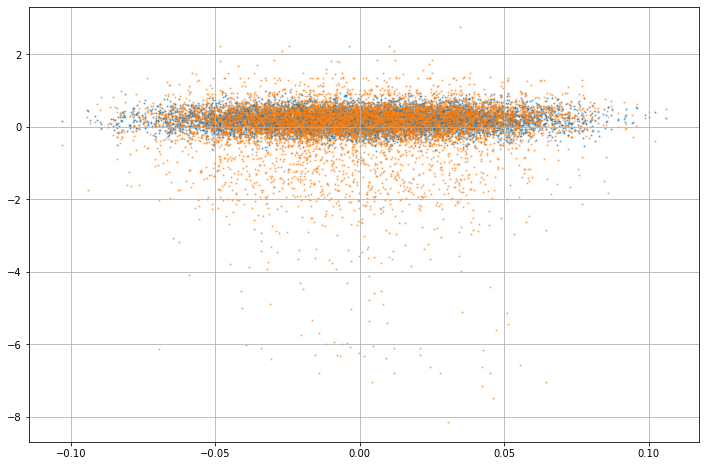

In [53]:
# just used to visualise the dristribution of the scores
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

kpca = KernelPCA(1, kernel='rbf')
low = kpca.fit_transform(all_x.view(8000, -1))

plt.figure(figsize=(12,8))
plt.grid()

guess = np.zeros(8000) + np.random.normal(0.2, 0.25, size=(8000,))

plt.scatter(low[:,0], guess, s=5, marker='.', alpha=.5)
plt.scatter(low[:,0], all_scores, s=5, marker='.', alpha=.5)

plt.savefig('random_scores.pdf', format='pdf')

# Writing scores for submission

In [0]:
import os

def writeScores(method_name, scores):
    fn = "predictions.txt"
    print("")
    with open(fn, 'w') as output_file:
        for idx,x in enumerate(scores):
            #out =  metrics[idx]+":"+str("{0:.2f}".format(x))+"\n"
            #print(out)
            output_file.write(f"{x}\n")

In [0]:
enet = ElasticNetCV()
enet.fit(all_x.view(8000, -1), all_scores)

predictions_de = enet.predict(de_test)

In [27]:
from google.colab import files
from zipfile import ZipFile

writeScores("enet",predictions_de)